In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import pickle

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report, f1_score, 
                             accuracy_score, roc_curve, auc, precision_recall_curve,mean_squared_error)


In [3]:
DATA_PATH = "C:/Users/aniru/Downloads/Laundry machine dataset.csv"

MODEL_SAVE_PATH = 'Bst_quality_classifier_model.pkl'
RANDOM_STATE = 42

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    sns.set_style("whitegrid")

print("Environment Setup Complete.")        

Environment Setup Complete.


In [4]:
def load_data(path):
    print(f"\n>>> Loading dataset from {path}...")
    try:
        df = pd.read_csv(path)
        print(f"Data Loaded Successfully. Shape: {df.shape}")
        return df
    except FileNotFoundError:
        print("Error: File not found. Please ensure 'Laundry machine dataset.csv' is in the directory.")
        return None

df = load_data(DATA_PATH)



>>> Loading dataset from C:/Users/aniru/Downloads/Laundry machine dataset.csv...
Data Loaded Successfully. Shape: (1000, 2)


In [5]:
def clean_text_regex(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['Complaint_Text'].apply(clean_text_regex)

# Encode Labels: QUALITY_ISSUE = 1, NON_QUALITY_ISSUE = 0
df['target'] = df['Label'].map({'QUALITY_ISSUE': 1, 'NON_QUALITY_ISSUE': 0})

print("First 5 rows of cleaned data:")
print(df[['Complaint_Text', 'cleaned_text', 'target']].head())

First 5 rows of cleaned data:
                                      Complaint_Text  \
0  Unit Fails to Start. Power is on, but drum won...   
1  Machine leaking water heavily from the bottom-...   
2  E40 error code constantly appears, door is loc...   
3  No hot water filling. Heating element continui...   
4  Extreme noise and vibration during high-speed ...   

                                        cleaned_text  target  
0  unit fails to start power is on but drum wont ...       1  
1  machine leaking water heavily from the bottomf...       1  
2  error code constantly appears door is locked c...       1  
3  no hot water filling heating element continuit...       1  
4  extreme noise and vibration during highspeed s...       1  


C:\Users\aniru\AppData\Local\Temp\ipykernel_3360\3481843330.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Label', data=df, palette='viridis')


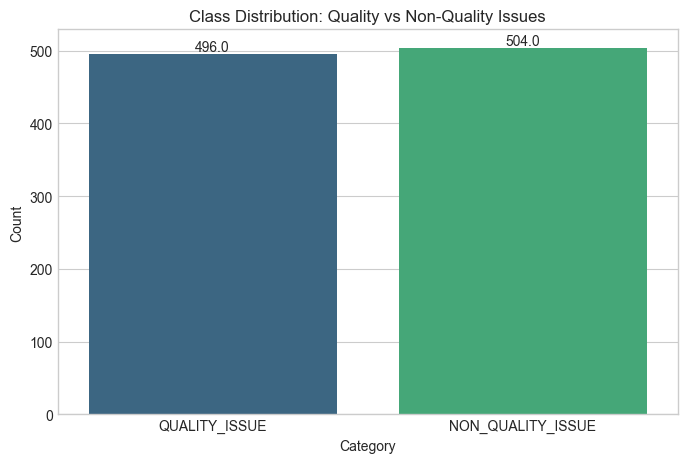

In [6]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Label', data=df, palette='viridis')
plt.title('Class Distribution: Quality vs Non-Quality Issues')
plt.xlabel('Category')
plt.ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()

In [7]:
X = df['cleaned_text']
y_binary = df['target']

# Split Data (Stratified to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
)

# Vectorize (TF-IDF)
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [12]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ),
    'SVM': SVC(
        kernel='linear',
        probability=True,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ),
    'Passive Aggressive': PassiveAggressiveClassifier(
        max_iter=1000,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        early_stopping=True
    )
}

In [ ]:

results = []

for name, model in models.items():
    # Train
    model.fit(X_train_tfidf, y_train)

    # Predict
    y_pred = model.predict(X_test_tfidf)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  

    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1 Score': f1,
        'RMSE': rmse
    })

    print(
        f"Model: {name} | "
        f"Accuracy: {acc:.4f} | "
        f"F1 Score: {f1:.4f} | "
        f"RMSE: {rmse:.4f}"
    )


Model: Logistic Regression | Accuracy: 0.9800 | F1 Score: 0.9796 | RMSE: 0.1414
Model: Naive Bayes | Accuracy: 0.9800 | F1 Score: 0.9796 | RMSE: 0.1414
Model: Random Forest | Accuracy: 0.9700 | F1 Score: 0.9697 | RMSE: 0.1732
Model: SVM | Accuracy: 0.9850 | F1 Score: 0.9846 | RMSE: 0.1225
Model: Passive Aggressive | Accuracy: 0.9800 | F1 Score: 0.9796 | RMSE: 0.1414


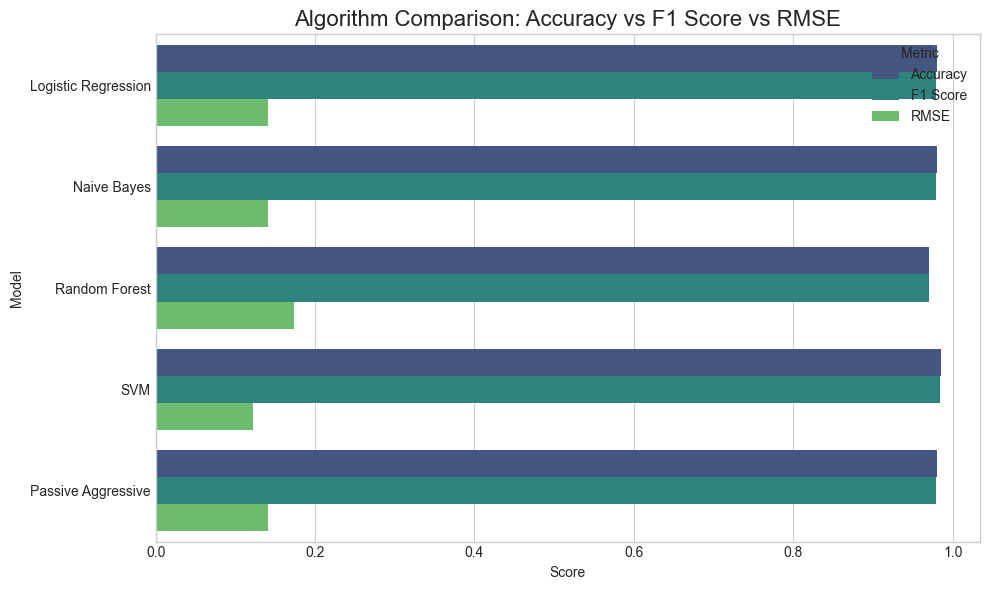

In [17]:
results_df = pd.DataFrame(results)


results_melted = pd.melt(
    results_df,
    id_vars="Model",
    value_vars=["Accuracy", "F1 Score", "RMSE"],
    var_name="Metric",
    value_name="Score"
)


plt.figure(figsize=(10, 6))
sns.barplot(
    x="Score",
    y="Model",
    hue="Metric",
    data=results_melted,
    palette="viridis"
)

plt.title("Algorithm Comparison: Accuracy vs F1 Score vs RMSE", fontsize=16)
plt.xlabel("Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()

In [18]:
best_model_name = results_df.sort_values(by='F1 Score', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n>>> Best Model Selected: {best_model_name}")


>>> Best Model Selected: SVM


Generating Learning Curve for SVM...


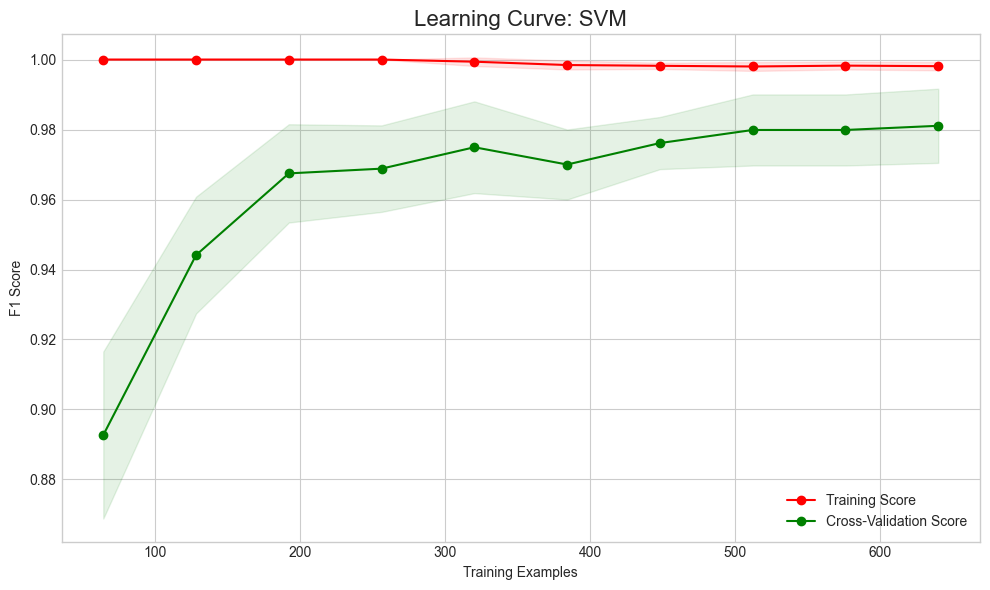

In [19]:
print(f"Generating Learning Curve for {best_model_name}...")
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_tfidf, y_train, cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.title(f"Learning Curve: {best_model_name}", fontsize=16)
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

ROC and Precision-Recall Curves


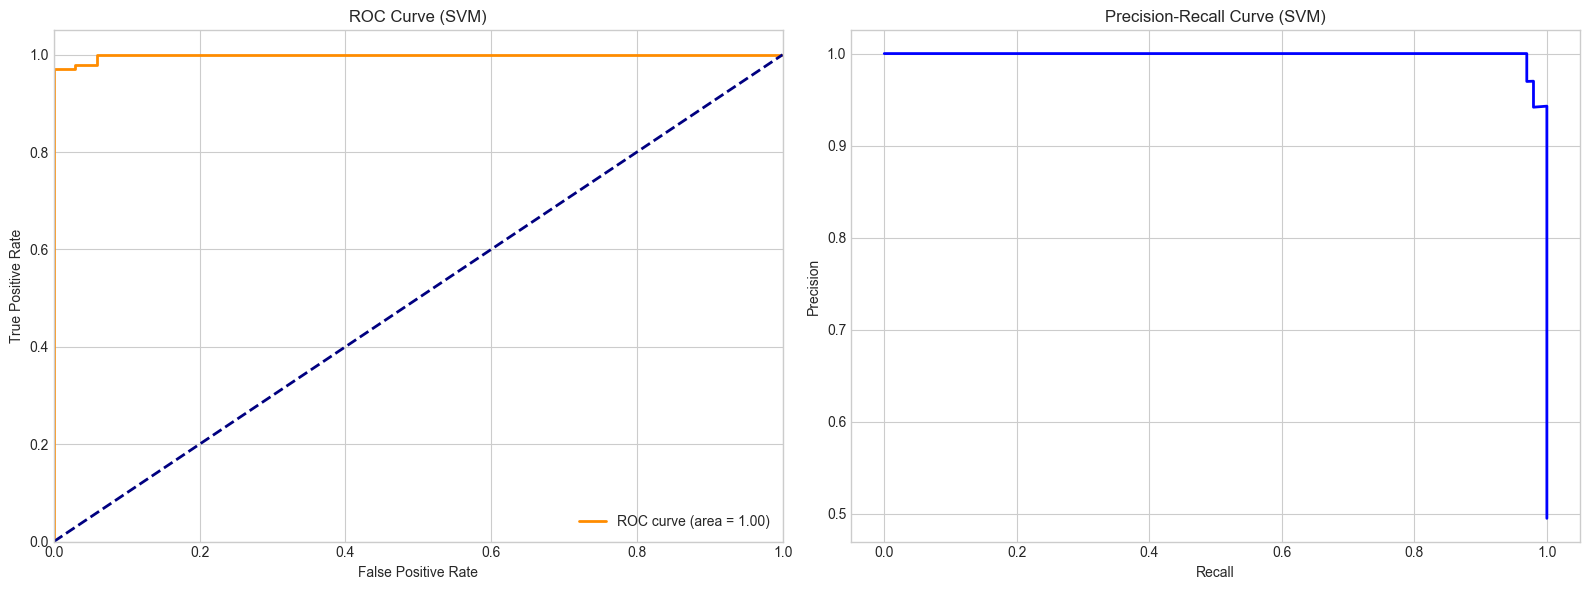

In [20]:
print("ROC and Precision-Recall Curves")


if hasattr(best_model, "predict_proba"):
    y_score = best_model.predict_proba(X_test_tfidf)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_score = best_model.decision_function(X_test_tfidf)
else:
    y_score = None
    print("Selected model does not support probability scores. Skipping ROC.")

if y_score is not None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curve ({best_model_name})')
    ax1.legend(loc="lower right")
    ax1.grid(True)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    ax2.plot(recall, precision, color='blue', lw=2)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall Curve ({best_model_name})')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()


Generating Confusion Matrix


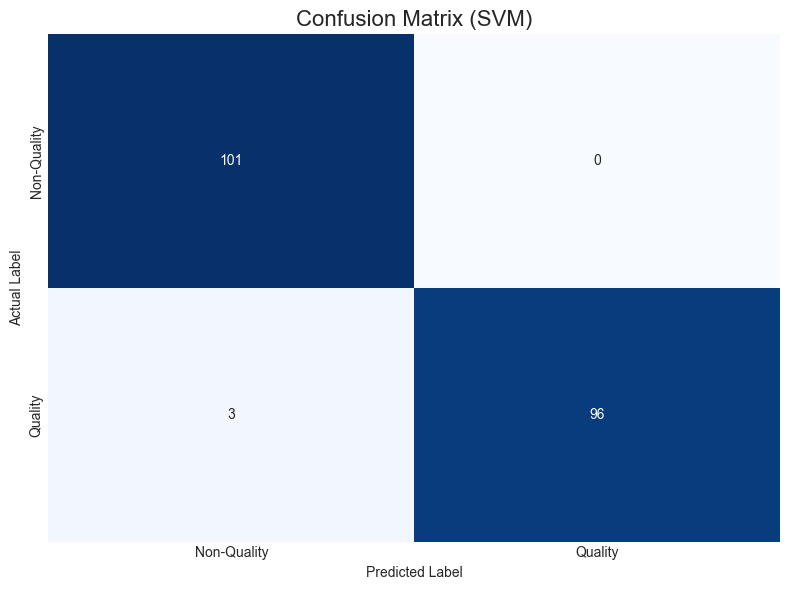

In [21]:
print("Generating Confusion Matrix")
y_pred_final = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Quality', 'Quality'],
            yticklabels=['Non-Quality', 'Quality'])
plt.title(f"Confusion Matrix ({best_model_name})", fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [22]:
final_pipeline = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', best_model)
])


with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(final_pipeline, f)

print(f"Best Model Pipeline ({best_model_name}) saved to: {MODEL_SAVE_PATH}")
print("Process Completed Successfully.")

Best Model Pipeline (SVM) saved to: Bst_quality_classifier_model.pkl
Process Completed Successfully.
